O Acidente Vascular Cerebral (AVC), também conhecido como derrame cerebral, é uma das principais causas de morte e incapacidade em todo o mundo. Ele ocorre quando o fluxo sanguíneo para uma parte do cérebro é interrompido, privando as células cerebrais de oxigênio e nutrientes vitais.  
Isso pode levar à morte das células cerebrais em poucos minutos, resultando em danos permanentes ao cérebro e a possibilidade de paralisia, dificuldade na fala e outras complicações graves.  
Esse problema tem grande prevalência no Brasil, e tem aumentado, em especial entre os mais jovens, segundo reportagem do R7 saúde.  
O objetivo desse trabalho é criar um modelo classificador para tentar, a partir de algumas features, classificar se uma certa pessoa teve ou não AVC. Caso ele apresente boa acúracia, pode-se compreender alguns fatores que são mais determinantes para causar um AVC. Os modelos utilizados foram árvore de decisão e gradiente descendente.

Fontes:
https://noticias.r7.com/saude/proporcao-de-jovens-que-morrem-de-avc-no-brasil-aumenta-em-2021-29102021

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad
import numpy as np

O primeiro passo realizado para lidar com os dados foi baixar e ler a base de dados do kaggle (disponível em: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), seguido da categorização de dados numéricos e transformação em one-hot-encoding. 


In [54]:
df = pd.read_csv('dados_avc.csv')
df.head(2)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


Como pode-se perceber, as features (dados de entrada do modelo) não estão padronizadas. Exsitem elementos numéricos nas colunas "age", "avg_glucose_level" e "bmi", que serão categorizadas. Os critérios para as categorias foram baseados em agumas pesquisas na internet. As fontes estão disponíveis nos comentários do código.   
   
Em seguida, foi aplicada a função "get_dummies" para realizar a conversão dos dados categóricos para o formato "one hot enconding". Esse formato cria uma coluna para cada categoria, de modo que somente uma delas tenha o sinal de verdadeiro (representado por 1). Um exemplo, seria a transformação da coluna “gender” que é transformada em “gender_Male”, “gender_Female” e “gender_Others”, então para o caso de um “gender” Male a primeira coluna terá valor 1 e as demais 0. 

In [55]:
# Preencher valores ausentes em 'bmi' com a média
df['bmi'].replace('N/A', float('nan'), inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
# Criar faixas etárias
age_bins = [0, 18, 35, 60, 100]
age_labels = ['Criança/Adolescente', 'Jovem', 'Adulto', 'Idoso']
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Criar categorias de IMC
bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ['Abaixo do peso', 'Peso normal', 'Sobrepeso', 'Obesidade']
df['bmi'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# Criar níveis de glicose no sangue
glucose_bins = [0, 70, 130, 200, 900]
glucose_labels = ['Baixo', 'Normal', "Alto", 'Muito alto']
df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

# Converter colunas categóricas usando one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','avg_glucose_level', 'bmi', 'age'], drop_first=True)
df.head(2)

,id,hypertension,heart_disease,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,9046,0,1,1,True,False,True,False,True,False,...,False,False,False,True,False,False,True,False,False,True
1,51676,0,0,1,False,False,True,False,False,True,...,False,False,False,True,False,True,False,False,False,True


Com o dataframe pronto, foi realizada a separação para o dataframe X (features) e Y (resultado). No caso em questão, as features eram idade, bmi, hipertensão, tipo de trabalho, entre outros, ao passo que o resultado é ter tido, ou não, AVC. 

In [56]:
X = df.drop(['stroke', 'id'], axis=1)
Y = df['stroke']
X.head(1)

,hypertension,heart_disease,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,...,smoking_status_smokes,avg_glucose_level_Normal,avg_glucose_level_Alto,avg_glucose_level_Muito alto,bmi_Peso normal,bmi_Sobrepeso,bmi_Obesidade,age_Jovem,age_Adulto,age_Idoso
0,0,1,True,False,True,False,True,False,False,True,...,False,False,False,True,False,False,True,False,False,True


Antes de realizar as manipulações de fato, são realizadas algumas operações apenas para homogeneizar os dados (todos os false viraram -1, bem como os 0), para permitir a análise. Além disso, foi escolhido -1 ou 1 para que todos os fatores estivessem na mesma escala, permitindo uma comparação mais simples e clara. 

In [57]:
## converting the 0 to -1
X = X.replace(0, -1)

## convering the True to 1 and False to -1
Y = Y.replace(0, -1)
X = X.replace(True, 1)
X = X.replace(False, -1)

X = X.astype('float64')
Y = Y.astype('float64')

Em seguida, foi a separação de dataset de treino e teste. Inicialmente, foi realizada uma divisão convencional, com 30% dos dados para treino e o restante para teste. Contudo, após realizar as análises do modelo e da hipótese nula, percebeu-se que a quantidade de casos de AVC era pouco significativa no dataset, acarretando nos modelos enviesados e escolhendo -1 (sem AVC) como saída. Com isso em mente, foi realizado um novo treinamento coletando todos os 249 casos com AVC e 251 dos restantes para montar o novo dataset. Esse dataset com 500 pessoas foi dividido 50% para treino e o restante para teste.

In [58]:
X = X[:500]
Y = Y[:500]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)


Após a separação do dataset, foi desenvolvido o código da função de perda. A ideia utilizada nessa implementação é que, existe uma “linha” que consegue dividir os dados em dois grupos: “teve AVC” e “não teve AVC”. Para determinar essa linha, inicia-se com um chute inicial e esse valor vai sendo melhorado conforme é realizado o “gradiente descendente” da função de perda. Basicamente busca-se a direção que maximiza o erro e percorre-se a direção contrária. Após várias iterações, a “linha” passa a ficar próxima o suficiente da ideal, com os menores erros possíveis (ou pelo menos próxima o suficiente do menor valor do mínimo local). Matematicamente temos:
$$ y = w_t x + b $$ 
Em que y é a classificação calculada pelo modelo, $w_t$ é o vetor de pesos das features, x é o vetor com features de cada pessoa e b é o “bias” (viés). 


In [59]:
def loss( parametros ):
    w, b, x, y = parametros
    est = w.T @ x + b
    mse = np_.mean( (est - y)**2)
    return mse

g = grad(loss)
x = np.array(X_train).T
y = np.array(Y_train)


Como pode-se perceber, x e y são os dados que separamos inicialmente, desse modo, eles não serão alterados pois representam os “pontos” que desejamos separar. Os valores que serão atualizados de forma iterativa são o vetor de pesos ($w_t$) e o bias ($b$). O procedimento consiste em escolher valores que podem ser aleatórios para o bias e os pesos (quanto mais próximo do valor real, mais rápido ele chegará no objetivo).   

Em seguida é realizado o cálculo do gradiente da função de perda e os valores da derivada em relação ao vetor de pesos e a b são subtraídos de cada um, respectivamente. Desse modo, estamos aumentando eles na direção da diminuição do erro.    

Entretanto, para evitar que ele “passe direto” pelo valor de erro mínimo, utiliza-se um fator para diminuir cada “passo” dado na direção do erro mínimo, aqui representado como $alpha$. Em geral são utilizadas potências de 10 negativas de 1 a 5. Nesse caso foram realizados alguns testes e $1/10^2$ apresentou um resultado satisfatório. 

In [60]:
w = np.random.randn(x.shape[0], 1)
b = 0.0
alpha = 10**-2

for n in range(20000):
    grad_ = g( (w, b, x, y) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]


Nessa célula é utilizado o método de Linear Regression da biblioteca sklearn, para realizar comparações entre o método utilizado na nossa análise e um método validado e amplamente utilizado e perceber as diferenças entre o modelo desenvolvido e um utilizado em nível de produção. 

In [61]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred[Y_pred > 0] = 1
Y_pred[Y_pred <= 0] = -1

Nessa célula é definida a função de acurácia do modelo, que consiste em verificar se ambos (y_teste[i] e y_predito[i]) apresentam o mesmo sinal e fazer a média (1 para casos positivos e 0 caso contrário).  Em seguida é realizada uma manipulação para facilitar a visualização dos dados, posteriormente. 

In [62]:
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))

## create tuples with value of w and X column name
w_tuples = []
w_lin_model = []
for i in range(len(w)):
    w_tuples.append((w[i][0], X.columns[i]))
    w_lin_model.append((model.coef_[i], X.columns[i]))

## sort the tuples
w_tuples.sort(reverse=True)
w_lin_model.sort(reverse=True)


Apresentação dos dados tanto do modelo desenvolvido, bem como do LinearRegression do Sklearn. Como pode-se perceber há grande similiridade entre os modelos. Além disso, é possível visualizar os principais fatores de risco para o AVC, segundo o modelo treinado, são "age_Idoso", "Age_adulto", "smoking_status_formerly smoked" e "hypertension". A maioria deles são relativamente condizentes com o senso comum. Porém o fator "Age adulto", foge um pouco, o que pode ser uma característica dos dados. 

In [63]:
x = np.array(X_test).T
y = np.array(Y_test)
y_est = w.T @ x + b
print(f"Acurácia do modelo desenvolvido: {accuracy(y, y_est) * 100:.2f}%")

df_nosso_modelo = pd.DataFrame(w_tuples, columns=['Valor Nosso Modelo', 'Tipo'])

df_nosso_modelo.head(8)

Acurácia do modelo desenvolvido: 71.60%


,Valor Nosso Modelo,Tipo
0,0.560939,age_Idoso
1,0.308282,age_Adulto
2,0.184083,smoking_status_formerly smoked
3,0.177507,hypertension
4,0.108114,avg_glucose_level_Normal
5,0.107727,smoking_status_smokes
6,0.079580,bmi_Sobrepeso
7,0.075128,heart_disease


In [64]:

accu = accuracy_score(Y_test, Y_pred)
print(f"Acurácia do modelo do sklearn: {accu * 100:.2f}%")


df_biblioteca = pd.DataFrame(w_lin_model, columns=['Valor Modelo Biblioteca', 'Tipo'])

Acurácia do modelo do sklearn: 71.60%


Essa célula apresenta a declaração da hipótese nula, que consiste na ideia de "chutar" sempre o caso que mais ocorre no dataset. Com isso, um dataset com grande volume de dados de uma categoria, digamos 70%, teria uma acurácia de 70%. Por isso, é importante comparar a acurácia do modelo e a avaliação da hipótese nula, já que um modelo que performa menos que 70% no caso apresentado é pouco confiável. 

In [65]:
def avaliar_hipotese_nula(y_test):
    return max(np.count_nonzero(y_test == 1), np.count_nonzero(y_test == -1)) / len(y_test)

Como era de se esperar, a hipótese nula é por volta de 50%, haja vista que na separação dos datasets de treino e teste, foram escolhidos somente 500 linhas de dados, para evitar viés de uma categoria. No original a hipótese nula era cerca de 94,19% e os modelos “chutavam” sempre que a pessoa não tinha apresentado um quadro AVC, para os casos de teste. 

In [66]:
hn = avaliar_hipotese_nula(y_test= Y.to_numpy())
print(f"Acurácia da hipótese nula: {hn * 100:.2f}%")

Acurácia da hipótese nula: 50.20%



Sobre o modelo de árvore de decisão, ele consiste em realizar uma série de “perguntas” para os dados, de modo que seja possível realizar uma série de divisões. O critério para cada divisão, aplicado no modelo, foi o da entropia. 

Quanto maior a entropia que aquela divisão gera, maior sua relevância e cada lado é dividido de forma mais “igualitária”. Desse modo, é possível ir separando os dados em categorias cada vez mais segmentadas, a ponto de termos grupos de dados em que só haja pessoas de um tipo de categoria, ou que apresentem uma maioria.

Com isso, no momento de avaliar um certo dado, o algoritmo realiza as verificações sucessivas, até encontrar um nó final e realiza a classificação conforme o que predomina nesse nó. Esse modelo pode ser entendido como uma série de “ifs” encadeados, porém de forma mais eficaz. 

Por exemplo, para uma linha com uma pessoa de categoria Idoso, sem problemas de coração , que já fumou, com bmi de “Peso normal”, com a árvore abaixo, teriamos o caminho: É idoso? Sim. Segue pelo ramo da direita. Tem obesidade? Não. Segue pelo ramo da esquerda. Já fumou? Sim. Segue pelo ramo da direita. E assim sucessivamente. 

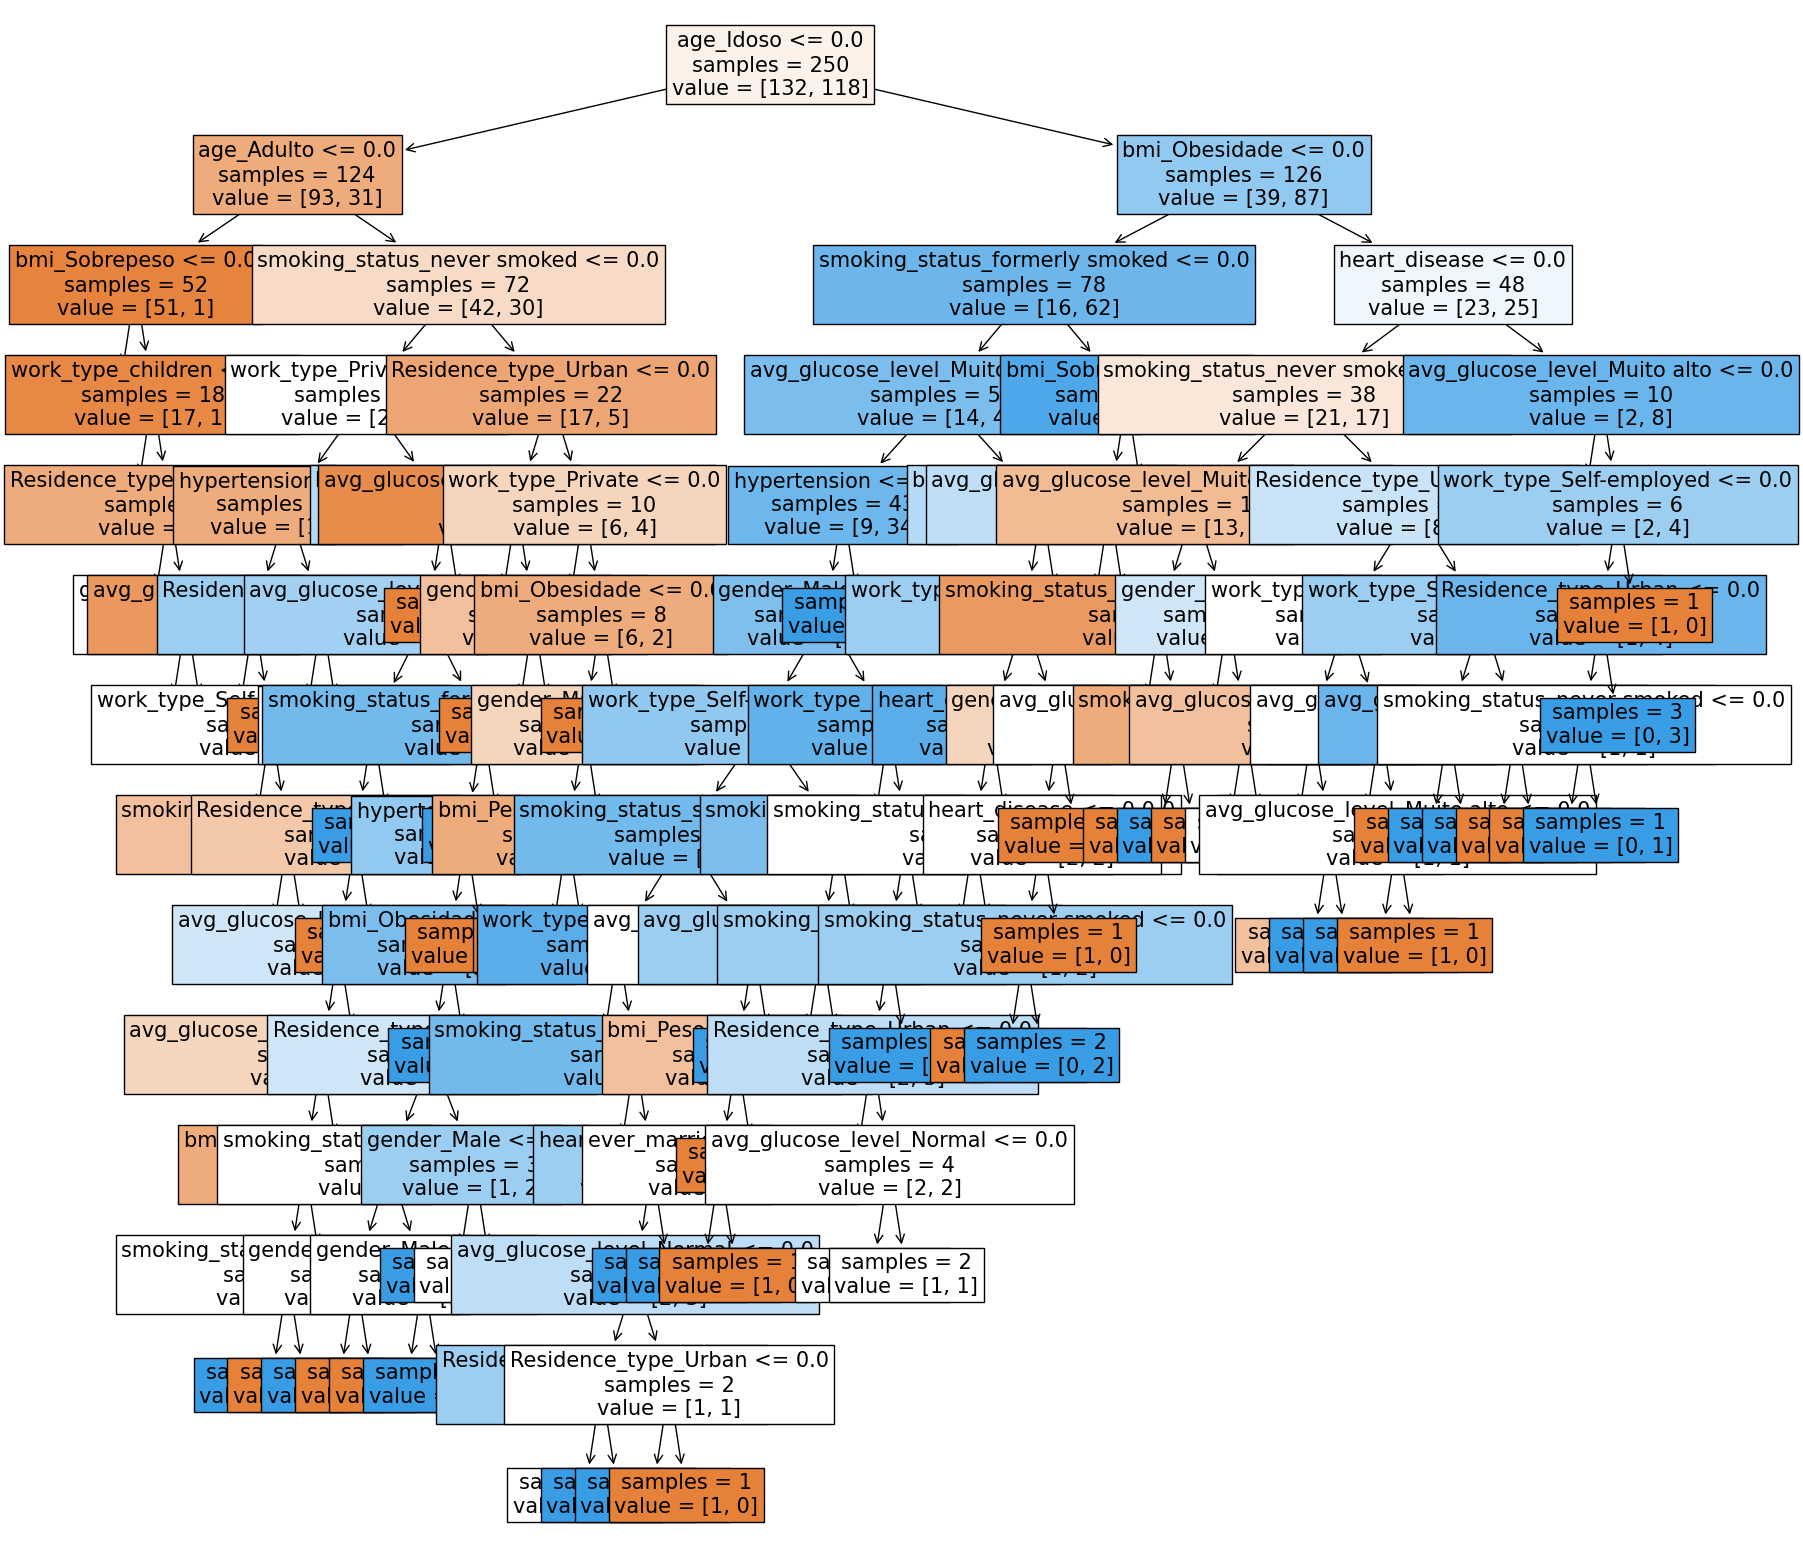

In [67]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy')

# Agora, vamos usar o método .fit() para ajustar os parâmetros da árvore:
tree.fit(X_train, Y_train)

# Podemos visualizar a árvore de decisão em uma figura!
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=X.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

Nessa célula é apresentada a acurácia do modelo da árvore de decisão.

In [68]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Acurácia do modelo de árvore de decisão:", accuracy)

Acurácia do modelo de árvore de decisão: 0.604


Por fim, foi utlizado método feature_importances, que apresenta quanto cada feature "pesou" na classificação, ao longo da árvore. Novamente, "Age_idoso" e "Age_adulto" performam como os maiores fatores do modelo

In [69]:
# Obter importância das características
feature_importances = tree.feature_importances_

# Criar DataFrame com as features e sua importância
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar o DataFrame pela importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Exibir o DataFrame
print(feature_importance_df)

                           Feature  Importance
21                       age_Idoso    0.157644
20                      age_Adulto    0.099353
15    avg_glucose_level_Muito alto    0.080836
9             Residence_type_Urban    0.067603
2                      gender_Male    0.067038
13        avg_glucose_level_Normal    0.065767
11     smoking_status_never smoked    0.063234
18                   bmi_Obesidade    0.057000
0                     hypertension    0.051585
6                work_type_Private    0.050157
17                   bmi_Sobrepeso    0.036724
10  smoking_status_formerly smoked    0.034595
7          work_type_Self-employed    0.032961
14          avg_glucose_level_Alto    0.031814
1                    heart_disease    0.030634
16                 bmi_Peso normal    0.027737
12           smoking_status_smokes    0.026562
8               work_type_children    0.010086
4                 ever_married_Yes    0.008670
5           work_type_Never_worked    0.000000
19           

A partir de pesquisas na literatura, constatou-se que o principal fator encontrado, idade "idoso" é um grande fator de risco, como pode ser verificado em: "Age-specific incidence, outcome, cost, and projected future burden of atrial fibrillation-related embolic vascular events: a population-based study" - Friberg L, Rosenqvist M, Lindgren A, Terént A, Norrving B, Asplund K. (2014). Este estudo foi publicado na revista Circulation.  

Neste estudo, os autores analisaram a incidência, os desfechos, os custos e o possível ônus futuro de eventos vasculares embólicos relacionados à fibrilação atrial em diferentes faixas etárias. Eles descobriram que a incidência de AVC aumenta com a idade, e a idade é um dos fatores de risco mais significativos para o AVC.